### Induction
This analysis aims to describe a better physical stores. The stakeholders are able to use the analysis result to figure out what kind of stores they should open in the future.

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import levene, f_oneway
from pingouin import welch_anova
from scikit_posthocs import posthoc_ttest, posthoc_tamhane

In [2]:
# this dataset is from Kaggle: https://www.kaggle.com/datasets/rouzbeh/stores-dataset/data
df = pd.read_csv("./data/Stores.csv", thousands=",")
df["Revenue"] = df["Revenue"] / (10**6) # make the revenue in million unit
df["AreaStore"] = df["AreaStore"] / 1000 # make the area of store in 1000 m2
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Store Number     118 non-null    int64  
 1   AreaStore        118 non-null    float64
 2   Property         118 non-null    object 
 3   Type             118 non-null    object 
 4   Old/New          118 non-null    object 
 5   Checkout Number  106 non-null    float64
 6   Revenue          118 non-null    float64
dtypes: float64(3), int64(1), object(3)
memory usage: 6.6+ KB


In [3]:
# drop rows containing null cells
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Store Number     106 non-null    int64  
 1   AreaStore        106 non-null    float64
 2   Property         106 non-null    object 
 3   Type             106 non-null    object 
 4   Old/New          106 non-null    object 
 5   Checkout Number  106 non-null    float64
 6   Revenue          106 non-null    float64
dtypes: float64(3), int64(1), object(3)
memory usage: 5.9+ KB


`106` physical stores have 5 attributes which can divided into 2 groups:
- `Categorical` attributes:
    - `Property`: store is owned or rented
    - `Type`: store's category
    - `Old/New`: store is new or old
- `Contineous` attributes:
    - `AreaStore`: the store's physical area in 1000 m2
    - `Checkout Number`: the number of cash registers

In [4]:
# the values of Property is not consistent, let's do some adjustment
df["Property"].value_counts()

Owned               39
Cooperate           24
Rental              24
Rental/Cooperate    12
Rental               5
Owned                2
Name: Property, dtype: int64

In [5]:
df[["Property","Type","Old/New"]] = df[["Property","Type","Old/New"]].applymap(str.strip)
df["Property"].value_counts()

Owned               41
Rental              29
Cooperate           24
Rental/Cooperate    12
Name: Property, dtype: int64

In [6]:
df["Type"].value_counts()

Express    53
Extra      30
Hyper      23
Name: Type, dtype: int64

In [7]:
df["Old/New"].value_counts()

New    90
Old    16
Name: Old/New, dtype: int64

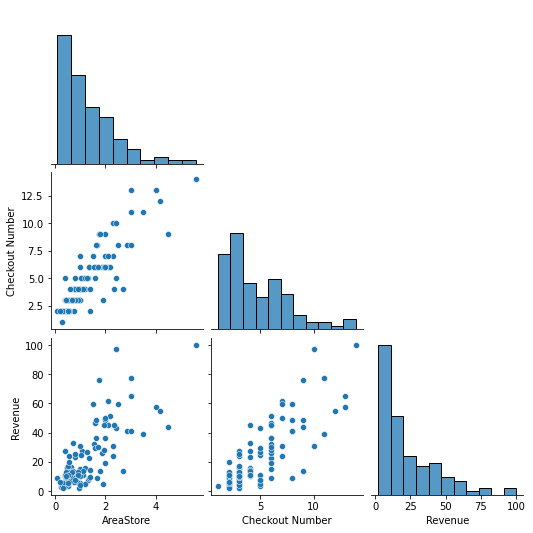

In [8]:
# let's see the relationship between AreaStore, Checkout Number vs Revenue
sns.pairplot(data=df[["AreaStore","Checkout Number","Revenue"]], corner=True)

<AxesSubplot: >

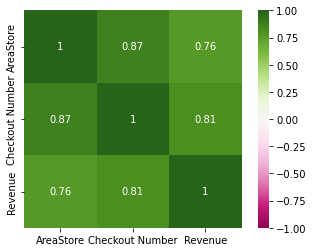

In [9]:
# the Pearson correlation ratio is pretty high
sns.heatmap(data=df[["AreaStore","Checkout Number","Revenue"]].corr(method="pearson"), cmap="PiYG", annot=True, vmin=-1, vmax=1, square=True, xticklabels=1, yticklabels=1)

It is not fair to compare two stores with the same categorical attributes, but different area in m2 or number of cash registers. Because the larger area in m2 or the more number of cash registers, the higher the revenue.\
This makes me add 2 new columns, which is `the average revenue per 1000 m2` and `the average revenue per 1 cash register`.

Now, we will figure out what kind of stores is better.

In [10]:
df["RevenuePerArea"] = df["Revenue"] / df["AreaStore"]
df["RevenuePerRegister"] = df["Revenue"] / df["Checkout Number"]

### Variance Test

In [11]:
factors = ["Property","Type","Old/New"]
dependent_list = ["Revenue","RevenuePerArea","RevenuePerRegister","AreaStore"]

In [12]:
test_of_homogeneity_of_variances = []
for factor in factors:
    for dependent_var in dependent_list:
        arr = df.groupby(factor)[dependent_var].agg(lambda x: list(x)).tolist()
        levene_test = levene(*arr, center="mean")
        stats, pvalue = levene_test.statistic, levene_test.pvalue
        test_of_homogeneity_of_variances.append({
            'factor':factor,
            'dependent_var':dependent_var,
            'statistics': stats,
            'pvalue':pvalue
        })

In [13]:
df_test_of_homogeneity_of_variances = pd.DataFrame(test_of_homogeneity_of_variances)

In [14]:
alpha = 0.05 # threshold for the null hypothesis rejected or accepted, if pvalue is greater than alpha, the null hypothesis is accepted
df_test_of_homogeneity_of_variances["accepted"] = df_test_of_homogeneity_of_variances["pvalue"] > alpha
df_test_of_homogeneity_of_variances.accepted.value_counts()

False    8
True     4
Name: accepted, dtype: int64

"The Levene test tests the null hypothesis that all input samples are from populations with equal variance".\
Therefore, if `pvalue` > `alpha`, the null hypothesis is accepted, which means the factor's values have the equal dependent variable's variance.

In this case, there are:
- 4 cases accepted: move to the F-test (_The prerequisite is the factor's values have the equal dependent variable's variance_) to test whether the mean of population is different
- 8 cases rejected: move to Robust Test (_In case the factor's values have not the equal dependent variable's variance_) to test whether the mean of population is different

Sample cases for equal variance test
Attribute / Factor: Type
Dependent variable: RevenuePerRegister


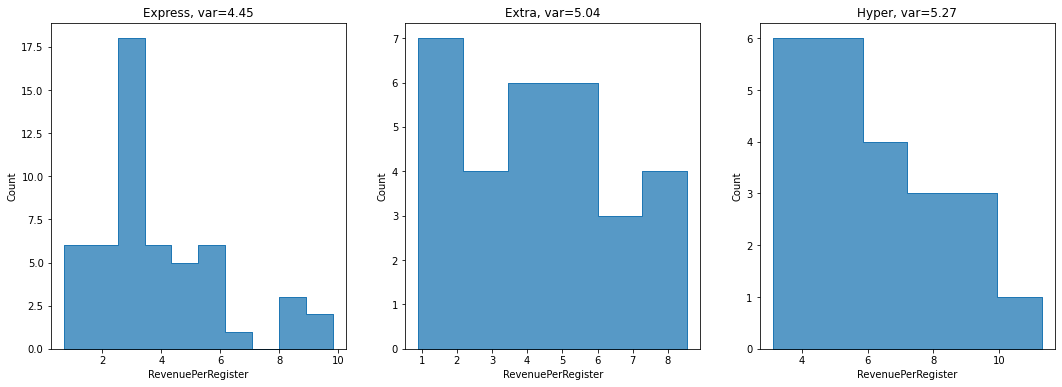

In [15]:
# the difference between histograms or variance values is pretty small
accepted_case = df_test_of_homogeneity_of_variances.query("accepted").sort_values("pvalue", ascending=False).iloc[0]
accepted_factor, accepted_dep_var = accepted_case["factor"], accepted_case["dependent_var"]
nvals = df[accepted_factor].nunique()

print("Sample cases for equal variance test")
print("Attribute / Factor:", accepted_factor)
print("Dependent variable:", accepted_dep_var)
fig, axs = plt.subplots(nrows=1, ncols=nvals, figsize=(nvals*6,6))

for idx, subdf in enumerate(df.groupby(accepted_factor)):
    ax = axs[idx]
    val, temp = subdf
    sns.histplot(data=temp, x=accepted_dep_var, element="step", ax=ax)
    ax.set_title(val)
    ax.set_title(val + ", var=" + '{:.2f}'.format(temp[accepted_dep_var].var()))

Sample cases for unequal variance test
Attribute / Factor: Type
Dependent variable: AreaStore


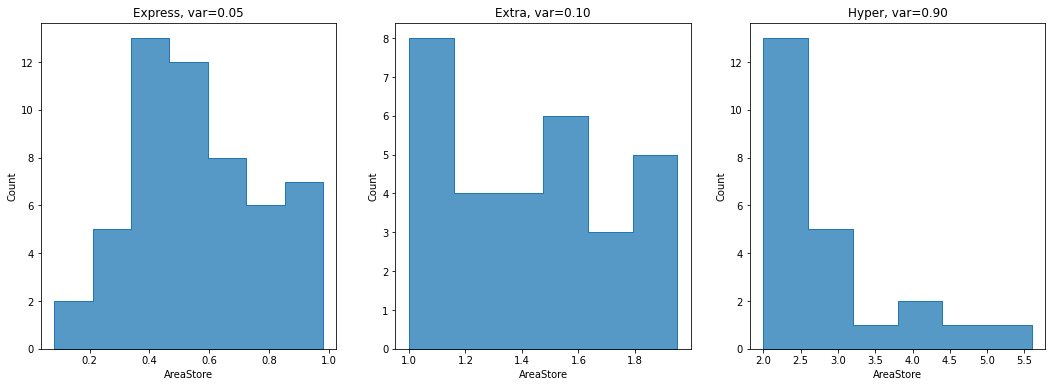

In [16]:
# the difference between histograms or variance values is pretty significant
rejected_case = df_test_of_homogeneity_of_variances.query("~accepted").sort_values("pvalue").iloc[0]
rejected_factor, rejected_dep_var = rejected_case["factor"], rejected_case["dependent_var"]
nvals = df[rejected_factor].nunique()

print("Sample cases for unequal variance test")
print("Attribute / Factor:", rejected_factor)
print("Dependent variable:", rejected_dep_var)
fig, axs = plt.subplots(nrows=1, ncols=nvals, figsize=(nvals*6,6))

for idx, subdf in enumerate(df.groupby(rejected_factor)):
    ax = axs[idx]
    val, temp = subdf
    sns.histplot(data=temp, x=rejected_dep_var, element="step", ax=ax)
    ax.set_title(val + ", var=" + '{:.2f}'.format(temp[rejected_dep_var].var()))

### Population Mean Test

4 cases with the equal variance test will be continued with F-test to test whether there is the difference between the mean of population

In [27]:
f_test = []
for row in df_test_of_homogeneity_of_variances.query("accepted").values:
    factor, dependent_var = row[0], row[1]
    arr = df.groupby(factor)[dependent_var].agg(lambda x: list(x)).to_list()
    result = f_oneway(*arr)
    stats, pvalue = result.statistic, result.pvalue
    f_test.append({
        'factor':factor,
        'dependent_var':dependent_var,
        'statistic':stats,
        'pvalue':pvalue
    })

In [30]:
# the null hypothesis is two or more groups have the same population mean
# if pvalue is less than alpha, the null hypothesis is not able to be rejected
# so, there is a difference between groups population mean
df_f_test = pd.DataFrame(f_test)
df_f_test["accepted"] = df_f_test["pvalue"] < alpha
df_f_test

,factor,dependent_var,statistic,pvalue,accepted
0,Property,RevenuePerArea,2.361806,0.075708,False
1,Type,RevenuePerArea,1.223685,0.298384,False
2,Type,RevenuePerRegister,8.516343,0.000378,True
3,Old/New,RevenuePerArea,1.201055,0.275642,False


In [31]:
# there is only case with difference between groups population mean
df_f_test["accepted"].value_counts()

False    3
True     1
Name: accepted, dtype: int64

8 cases with the unequal variance test will be continued with Robust Test to test whether there is the difference between the mean of population

In [35]:
robust_test = []
for row in df_test_of_homogeneity_of_variances.query("~accepted").values:
    factor, dependent_var = row[0], row[1]
    result = welch_anova(data=df, dv=dependent_var, between=factor).iloc[0]
    stats, pvalue = result["F"], result["p-unc"]
    robust_test.append({
        'factor':factor,
        'dependent_var':dependent_var,
        'statistic':stats,
        'pvalue':pvalue
    })

In [36]:
# the null hypothesis is two or more groups have the same population mean
# if pvalue is less than alpha, the null hypothesis is not able to be rejected
# so, there is a difference between groups population mean
df_robust_test = pd.DataFrame(robust_test)
df_robust_test["accepted"] = df_robust_test["pvalue"] < alpha
df_robust_test

,factor,dependent_var,statistic,pvalue,accepted
0,Property,Revenue,17.565578,2.664274e-07,True
1,Property,RevenuePerRegister,12.910160,4.010167e-06,True
2,Property,AreaStore,15.100287,1.417051e-06,True
3,Type,Revenue,43.349435,1.967630e-10,True
4,Type,AreaStore,141.900549,5.665081e-19,True
5,Old/New,Revenue,20.360189,3.542336e-05,True
6,Old/New,RevenuePerRegister,12.766758,1.142828e-03,True
7,Old/New,AreaStore,24.948206,5.597949e-06,True


In [38]:
# all 8 cases are accepted to have difference between groups population mean
df_robust_test.accepted.value_counts()

True    8
Name: accepted, dtype: int64

### Determine which group is greater/less than others

So, there are 9 cases with different population mean between groups, including:
- 1 case has the same population variance: using LSD post-hoc test to find which group is greater/less than others

In [58]:
df_lsd_test = pd.DataFrame()
for row in df_f_test.query("accepted").values:
    factor, dependent_var = row[0], row[1]
    result = posthoc_ttest(a=df, val_col=dependent_var, group_col=factor, pool_sd=True)
    result = result.reset_index().melt(id_vars="index", value_vars=result.columns, var_name="group2", value_name="pvalue")
    result.rename(columns={"index":"group1"}, inplace=True)
    mean_gr = df.groupby(factor, as_index=False)[dependent_var].mean()
    result = result.merge(mean_gr.rename(columns={factor:"group1",dependent_var:"mean_gr1"}))
    result = result.merge(mean_gr.rename(columns={factor:"group2",dependent_var:"mean_gr2"}))
    result = result[
        (result["pvalue"] < alpha) &
        (result["mean_gr1"] > result["mean_gr2"])
    ]
    result[["factor", "dependent_var"]] = [factor,dependent_var]
    df_lsd_test = pd.concat([df_lsd_test, result])

- 8 cases have the different population variance: using Tamhane test to find which group is greater/less than others

In [61]:
df_tamhane_test = pd.DataFrame()
for row in df_robust_test.query("accepted").values:
    factor, dependent_var = row[0], row[1]
    result = posthoc_tamhane(a=df, val_col=dependent_var, group_col=factor)
    result = result.reset_index().melt(id_vars="index", value_vars=result.columns, var_name="group2", value_name="pvalue")
    result.rename(columns={"index":"group1"}, inplace=True)
    mean_gr = df.groupby(factor, as_index=False)[dependent_var].mean()
    result = result.merge(mean_gr.rename(columns={factor:"group1",dependent_var:"mean_gr1"}))
    result = result.merge(mean_gr.rename(columns={factor:"group2",dependent_var:"mean_gr2"}))
    result = result[
        (result["pvalue"] < alpha) &
        (result["mean_gr1"] > result["mean_gr2"])
    ]
    result[["factor", "dependent_var"]] = [factor,dependent_var]
    df_tamhane_test = pd.concat([df_tamhane_test, result])

In [79]:
df_comparison_test = pd.concat([df_lsd_test, df_tamhane_test])
df_comparison_test.sort_values(["dependent_var","factor","group1"], inplace=True)
df_comparison_test.reset_index(drop=True, inplace=True)
df_comparison_test

,group1,group2,pvalue,mean_gr1,mean_gr2,factor,dependent_var
0,New,Old,1.119587e-05,1.406122,0.658423,Old/New,AreaStore
1,Owned,Cooperate,1.719658e-07,1.921195,0.758032,Property,AreaStore
2,Owned,Rental,1.661528e-06,1.921195,0.746690,Property,AreaStore
3,Extra,Express,0.000000e+00,1.423133,0.555845,Type,AreaStore
4,Hyper,Extra,1.012083e-06,2.823130,1.423133,Type,AreaStore
5,Hyper,Express,1.978128e-10,2.823130,0.555845,Type,AreaStore
6,New,Old,7.084547e-05,25.261733,10.931250,Old/New,Revenue
7,Owned,Cooperate,1.205685e-08,39.111134,11.221000,Property,Revenue
8,Owned,Rental,9.802822e-08,39.111134,12.554103,Property,Revenue
9,Owned,Rental/Cooperate,3.427845e-03,39.111134,17.627208,Property,Revenue


### Conclusion
Now, we can realize the difference between groups in details.
- For the store area:
    - Old/New: NEW > OLD
    - Property: OWNED > RENTAL, COOPERATE
    - Type: HYPER > EXTRA > EXPRESS

- For total revenue:
    - Old/New: NEW > OLD
    - Property: OWNED > RENTAL, COOPERATE, RENTAL/COOPERATE
    - Type: HYPER > EXTRA, EXPRESS

However, as shared above, it is unfair when the store has more cash registers or wider area. We should use the revenue per register or area.
- For the revenue per cash register:
    - Old/New: NEW > OLD
    - Property: OWNED > RENTAL, COOPERATE, RENTAL/COOPERATE
    - Type: HYPER, EXTRA > EXPRESS